In [1]:
include("../../src/CoherentStructures.jl") #this is terrible but neccessary during development (?)

Main.CoherentStructures

In [2]:
using StreamMacros, Main.CoherentStructures
using Tensors, Arpack, Distances
using Plots
using OrdinaryDiffEq

In [3]:
# Parameters
grid_resolution        = 100
quadrature_order       = 5
selected_ev            = 2        # which Eigenvector to choose
ϵ                      = 0.2      # perturbation
t₀                      = 0.6     # parameter value corresponding to ϵ=0
solver_tolerance       = 1e-5
solver                 = OrdinaryDiffEq.BS5()
δ                      = 0
ξ                      = 0;

In [4]:
rot_double_gyre = @velo_from_stream Ψ_rot_dgyre begin
    st          = heaviside(t)*heaviside(1-t)*t^2*(3-2*t) + heaviside(t-1)
    heaviside(x)= 0.5*(sign(x) + 1)
    Ψ_P         = sin(2π*x)*sin(π*y)
    Ψ_F         = sin(π*x)*sin(2π*y)
    Ψ_rot_dgyre = (1-st) * Ψ_P + st * Ψ_F
end
T(x,p) = flow(rot_double_gyre, x, [0.0, t₀ + p],
    tolerance = solver_tolerance, solver = solver)[end]

T (generic function with 1 method)

In [5]:
LL, UR = (0.0+δ, 0.0+δ), (1.0-δ, 1.0-δ)
ctx, _ = regularTriangularGrid((grid_resolution, grid_resolution), LL, UR, quadrature_order = quadrature_order);

In [6]:
M = assembleMassMatrix(ctx);

In [7]:
@time D⁰ = assembleStiffnessMatrix(ctx)
@time D¹ = adaptiveTOCollocationStiffnessMatrix(ctx, y -> T(y,0))
K = 0.5(D⁰+D¹);

  0.448142 seconds (1.73 M allocations: 98.791 MiB, 6.12% gc time)
 16.044764 seconds (54.10 M allocations: 3.064 GiB, 5.46% gc time)


In [8]:
# solve the linear system
@time λ₀, u₀ = eigs(K, M, which=:SM)
@assert all(imag.(u₀) .== 0)
@assert all(imag.(λ₀) .== 0)
u₀ = real.(u₀[:,selected_ev])
λ₀ = real.(λ₀[selected_ev])
u₀ = u₀ ./ sqrt(u₀'*M*u₀)        # L2 normalization
u₀ = u₀*sign(sum(u₀))
λ₀

  3.111314 seconds (9.09 M allocations: 534.688 MiB, 3.85% gc time)


-50.25534399796264

In [9]:
# assemble the linear response matrix L
@time L = adaptiveTOCollocationLinearResponseMatrix(ctx, T, 0);

  6.153573 seconds (22.29 M allocations: 1.374 GiB, 10.40% gc time)


In [10]:
# solve the system for the derivative u_dot
lhs = [K-λ₀*M   -M*u₀
        u₀'*M      0]
rhs = [-L*u₀    ;  0]

@time b = lhs \ rhs
u_dot = b[1:end-1]
λ_dot = b[end]

  0.816066 seconds (2.39 M allocations: 189.355 MiB, 4.35% gc time)


-48.23021791139894

In [11]:
# calculate the exact uϵ
D¹ϵ = adaptiveTOCollocationStiffnessMatrix(ctx, y -> T(y,ϵ))
Kϵ = 0.5(D⁰+D¹ϵ)
λϵ, uϵ = eigs(Kϵ, M, which=:SM)
@assert all(imag.(uϵ) .== 0)
@assert all(imag.(λϵ) .== 0)
uϵ = real.(uϵ[:,selected_ev])
λϵ = real.(λϵ[selected_ev])
uϵ = uϵ ./ sqrt(uϵ'*M*uϵ)
uϵ = uϵ*sign(sum(uϵ))
λϵ

-61.43189853963866

In [12]:
λ₀ + ϵ*λ_dot

-59.90138758024243

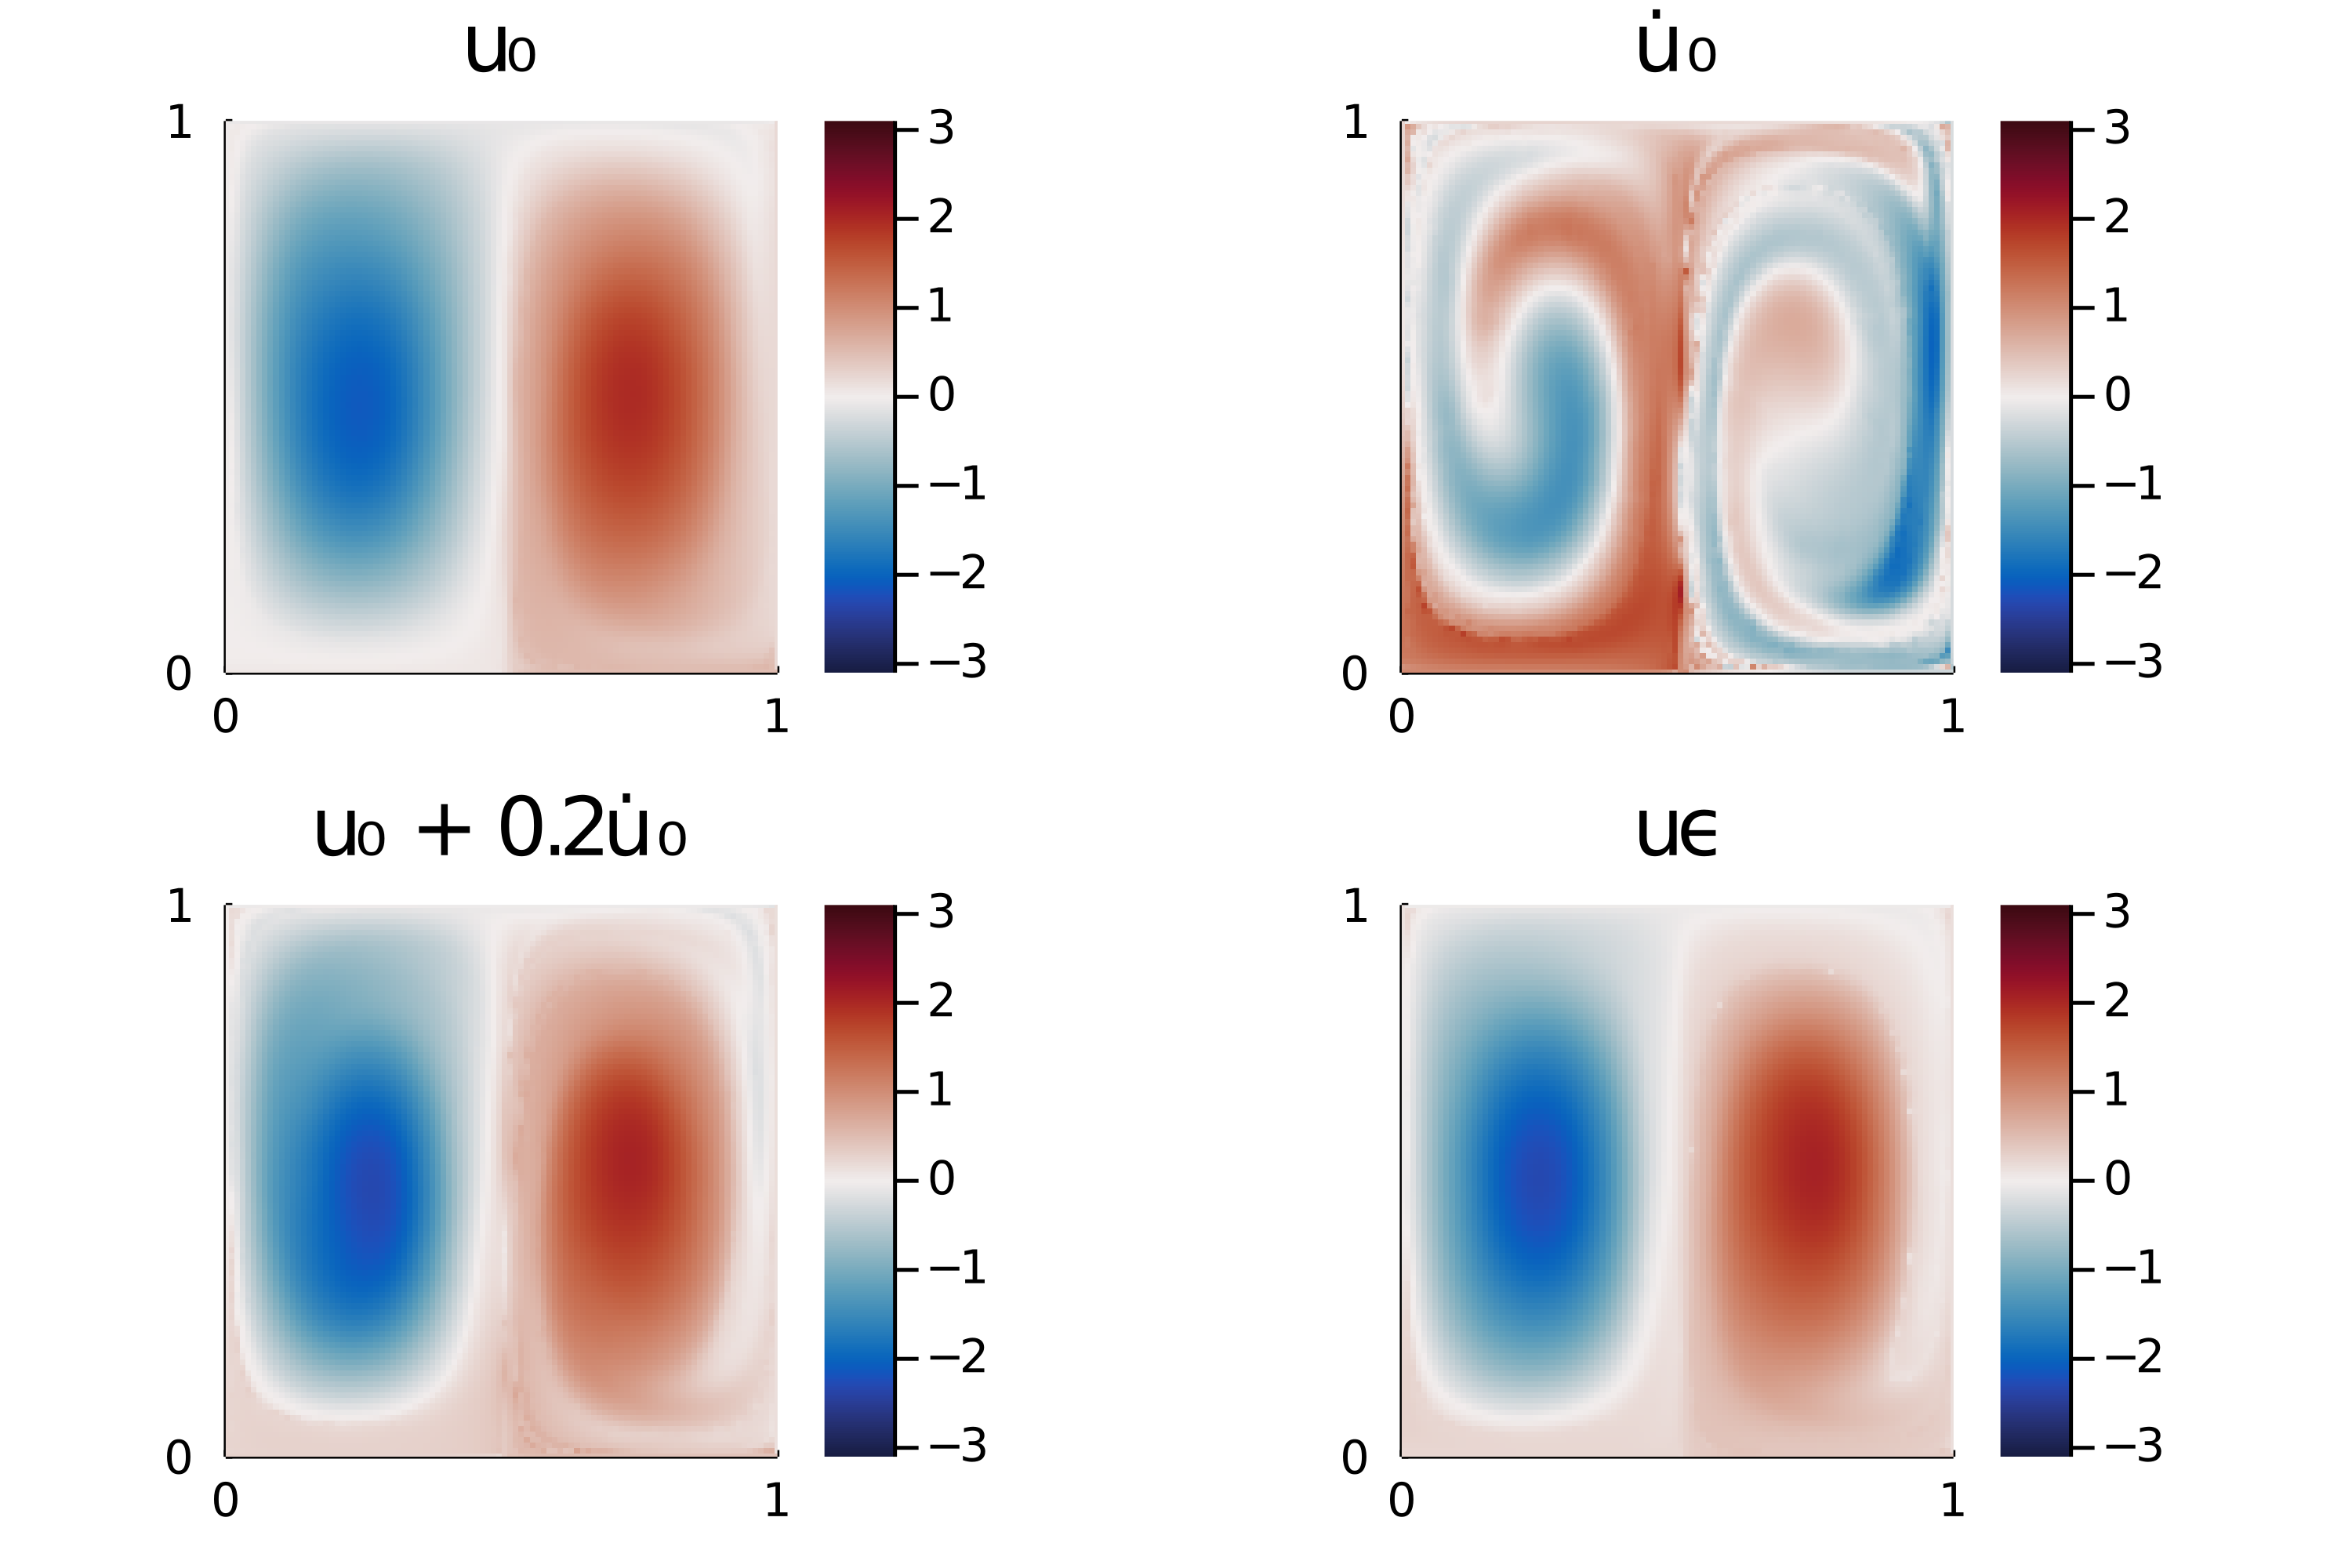

In [13]:
color =    :balance
xticks =   0:1:1
yticks =   0:1:1
colorbar = :left
cmin =     -3.1
cmax =     3.1
cmin_lr =  -3.1
cmax_lr =  3.1
#unfortunately there is no option for colorbar ticks


original      = plot_u(ctx, u₀,  grid_resolution, grid_resolution, title="u₀",
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
derivative    = plot_u(ctx, u_dot,       grid_resolution, grid_resolution, title="u̇ ₀",
                colorbar=colorbar, color=color, clims=(cmin_lr,cmax_lr), xticks=xticks, yticks=yticks)
extrapolated  = plot_u(ctx, u₀ + ϵ*u_dot, grid_resolution, grid_resolution, title="u₀ + $(ϵ)u̇ ₀",
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
exact         = plot_u(ctx, uϵ,          grid_resolution, grid_resolution, title="uϵ",
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
Plots.plot(original,derivative,extrapolated,exact, fmt=:png, dpi=500)

In [14]:
using Contour

In [15]:
function dynamic_cheeger_value_levelset(levelset)
    curves = lines(levelset)
    if length(curves) != 1 
        @warn "Currently only connected levelsets are allowed! Levelset: ", level(levelset)
    end
    curve = curves[1]
    return dynamic_cheeger_value(ctx,curve,x -> T(x,0),tolerance=1e-10)
end
function dynamic_cheeger_value_levelset_nonnegative(levelset)
    if level(levelset) < 0
        return Inf
    end
    curves = lines(levelset)
    if length(curves) != 1 
        @warn "Currently only connected levelsets are allowed! Levelset: $(level(levelset))"
    end
    curve = curves[1]
    return dynamic_cheeger_value(ctx,curve,x -> T(x,0),tolerance=1e-10)
end

best_levelset, best_value = get_minimal_levelset(
    ctx,u₀,dynamic_cheeger_value_levelset_nonnegative,n_candidates=1000)
print("Dynamic Cheeger value:\t",best_value,"\n")
print("Levelset:\t\t",level(best_levelset),"\n")

┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.003949211185104051
└ @ Main In[15]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.008057445072084501
└ @ Main In[15]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.012165678959064508
└ @ Main In[15]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.016273912846044958
└ @ Main In[15]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.020382146733024964
└ @ Main In[15]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.024490380620005414
└ @ Main In[15]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.02859861450698542
└ @ Main In[15]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.03270684839396587
└ @ Main In[15]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.03681508228094588
└ @ Main In[15]:15
┌ Warning: Currently o

Dynamic Cheeger value:	7.113580948034643
Levelset:		0.016273912846044958


cheeger value		length			length transported	volume
8.389372514872097	1.7809880645802665	1.7263819775743274	0.20903649444204392
10.761691989714029	4.024508550452366	6.727742411956809	0.49956135952813563


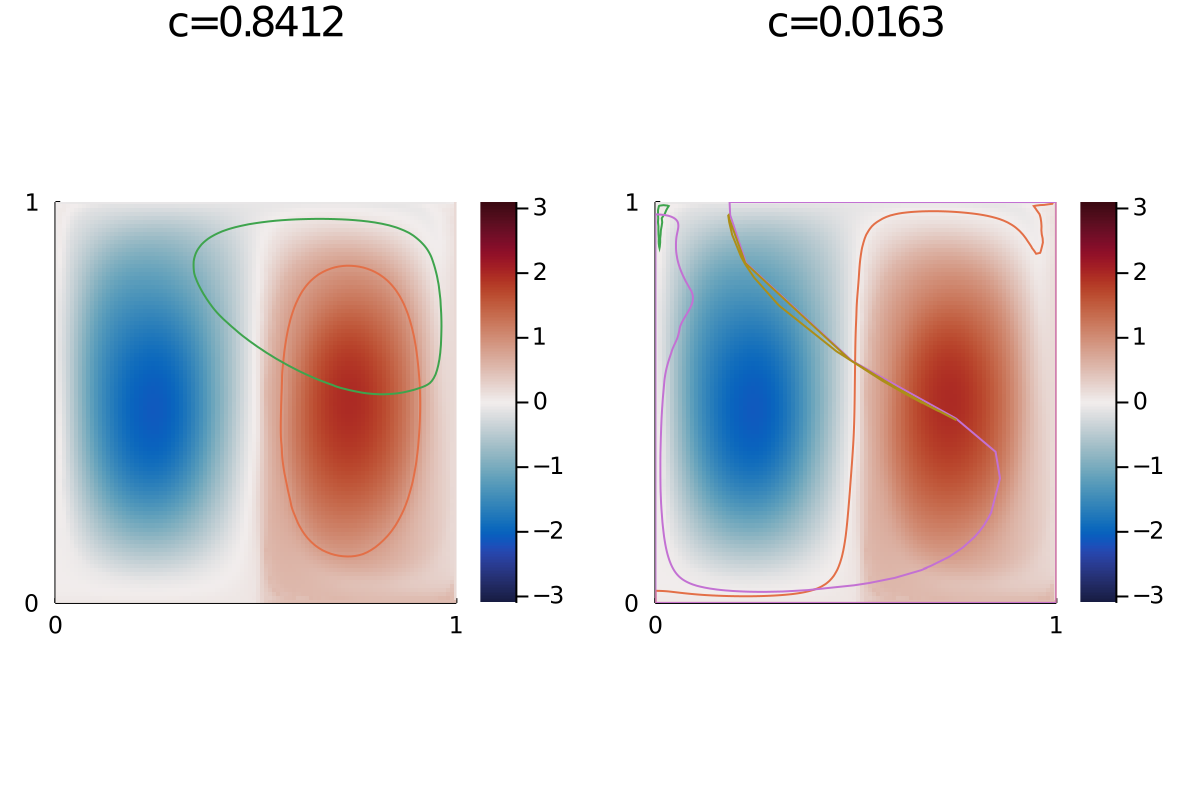

In [16]:
# value from paper
c_paper = 0.8412
plot_paper = plot_u(ctx, u₀,  grid_resolution, grid_resolution, title="c=$(round(c_paper,digits=4))",
        colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks,legend=false)

curves = lines(get_levelset(ctx, u₀, c_paper))
curves_moved = [Main.CoherentStructures.apply2curve(x->T(x,0),c) for c in curves]

cheeger_value = dynamic_cheeger_value(ctx, curves[1], x->T(x,0))
print("cheeger value\t\tlength\t\t\tlength transported\tvolume\n")
print("$(cheeger_value)\t$(Main.CoherentStructures.getLength(curves[1]))\t",
    "$(Main.CoherentStructures.getLength(curves_moved[1]))\t$(Main.CoherentStructures.getEuclideanArea(ctx,curves[1]))\n")

for c in curves
    Plots.plot!(coordinates(c))
end
for c in curves_moved
    Plots.plot!(coordinates(c))
end

# our value
c_ours = level(best_levelset)
plot_ours = plot_u(ctx, u₀,  grid_resolution, grid_resolution, title="c=$(round(c_ours,digits=4))",
        colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks,legend=false)

curves = lines(get_levelset(ctx, u₀, c_ours))
curves = [Main.CoherentStructures.closeCurve(ctx,c) for c in curves]
curves_moved = [Main.CoherentStructures.apply2curve(x->T(x,0),c) for c in curves]

cheeger_value = dynamic_cheeger_value(ctx, curves[1], x->T(x,0))
print("$(cheeger_value)\t$(Main.CoherentStructures.getLength(curves[1]))\t",
    "$(Main.CoherentStructures.getLength(curves_moved[1]))\t$(Main.CoherentStructures.getEuclideanArea(ctx,curves[1]))\n")

for c in curves
    Plots.plot!(coordinates(c))
end
for c in curves_moved
    Plots.plot!(coordinates(c))
end
Plots.plot(plot_paper,plot_ours,fmt=:png,dpi=200,legend=false,aspectratio=1,xlims=(0,1),ylims=(0,1))

In [17]:
function plot_vectorfield(xs,ys,dx,dy;scale=1,step=1)
    xs, ys = xs[1:step:end], ys[1:step:end]
    x_coords = repeat(xs, outer=length(ys))
    y_coords = repeat(ys, inner=length(xs))
    dx, dy = scale.*dx[1:step:end,1:step:end], scale.*dy[1:step:end,1:step:end]
    quiver(x_coords,y_coords,quiver=(vec(dx),vec(dy)))
end

plot_vectorfield (generic function with 1 method)

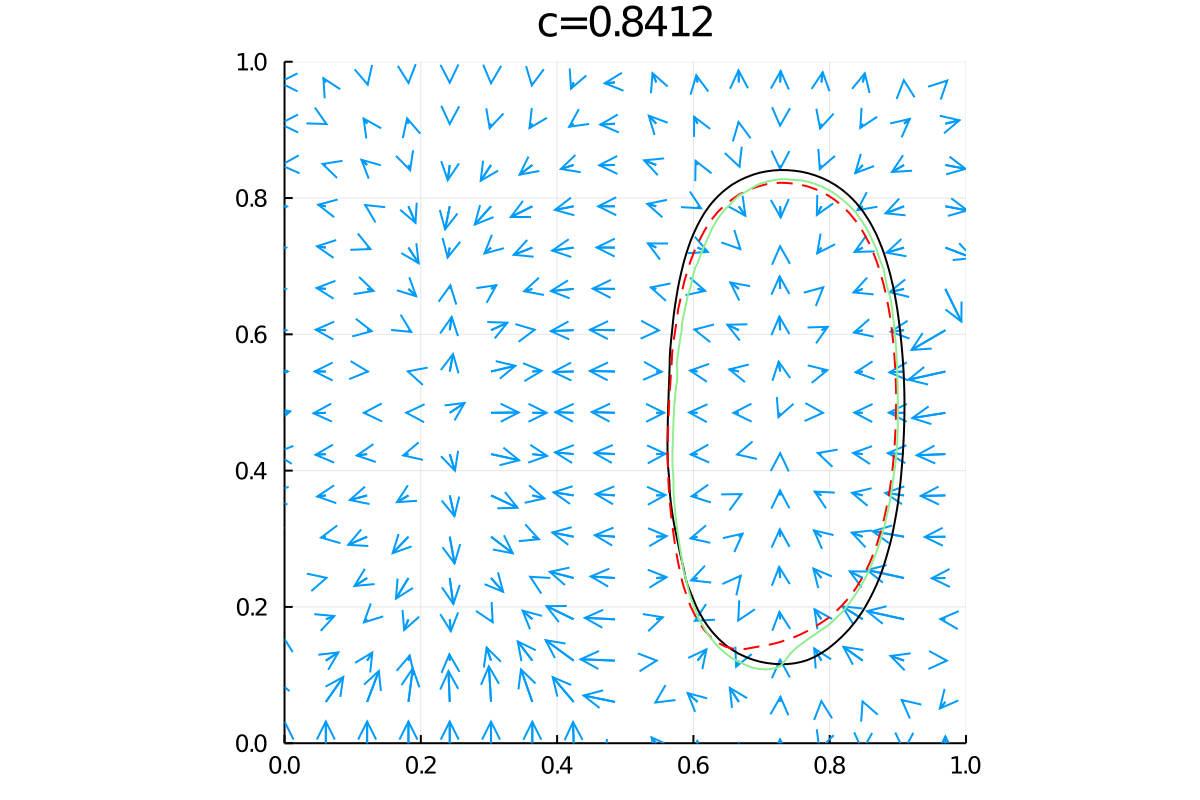

In [18]:
plot_vectorfield(get_levelset_evolution(ctx,u₀,u_dot)...,scale=0.03,step=6)
curves           = lines(get_levelset(ctx, u₀, c_paper))
curves_epsilon   = lines(get_levelset(ctx, uϵ, c_paper))
curves_predicted = lines(get_levelset(ctx, u₀ + ϵ*u_dot, c_paper))

for c in curves
    plot!(coordinates(c),color=:black)
end
for c in curves_epsilon
    plot!(coordinates(c),color=:red,linestyle=:dash)
end
for c in curves_predicted
    plot!(coordinates(c),color=:lightgreen)
end
Plots.plot!(fmt=:png,dpi=200,legend=false,aspectratio=1,xlims=(0,1),ylims=(0,1),title="c=$(round(c_paper,digits=4))")

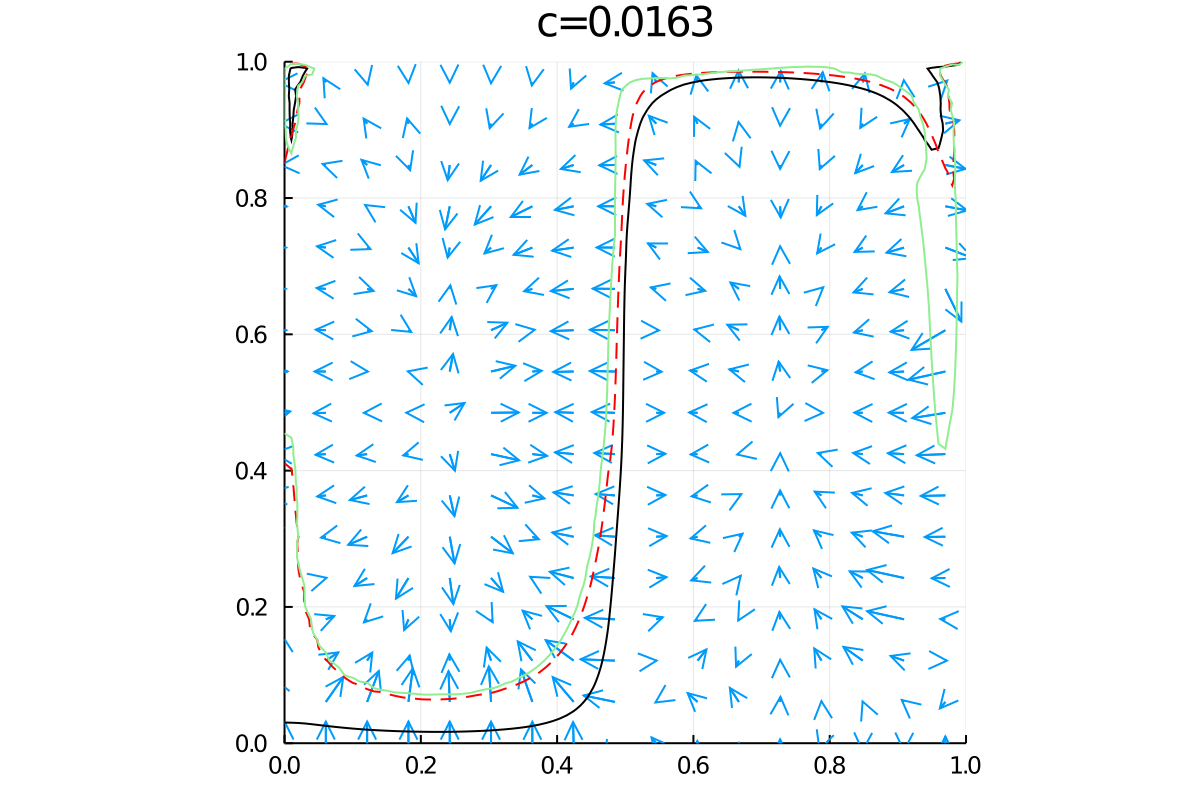

In [19]:
plot_vectorfield(get_levelset_evolution(ctx,u₀,u_dot)...,scale=0.03,step=6)
curves           = lines(get_levelset(ctx, u₀, c_ours))
curves_epsilon   = lines(get_levelset(ctx, uϵ, c_ours))
curves_predicted = lines(get_levelset(ctx, u₀ + ϵ*u_dot, c_ours))

for c in curves
    plot!(coordinates(c),color=:black)
end
for c in curves_epsilon
    plot!(coordinates(c),color=:red,linestyle=:dash)
end
for c in curves_predicted
    plot!(coordinates(c),color=:lightgreen)
end
Plots.plot!(fmt=:png,dpi=200,legend=false,aspectratio=1,xlims=(0,1),ylims=(0,1),title="c=$(round(c_ours,digits=4))")